In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### O presente notebook visa treinar: random forest regressor, knn, gradient boosting e gridsearch. Para isso foi utilizado um csv com preços das casas na califórnia.

O principal objetivo aqui não é necessariamente a predição, mas trabalhar os algoritmos acima. Tentaremos prever o preço mediano das casas segundo alguma variável explicativa.

In [2]:
df = pd.read_csv("preco_casas.csv")
print(df.shape)
df.head()

(20640, 10)


,longitude,latitude,idade_mediana_das_casas,total_comodos,total_quartos,populacao,familias,salario_mediano,preco_mediano_das_casas,proximidade_ao_mar
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,PERTO DA BAÍA
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,PERTO DA BAÍA
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,PERTO DA BAÍA
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,PERTO DA BAÍA
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,PERTO DA BAÍA


### Tratando os dados:

In [3]:
#Verificando Nulls e dtypes:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   longitude                20640 non-null  float64
 1   latitude                 20640 non-null  float64
 2   idade_mediana_das_casas  20640 non-null  float64
 3   total_comodos            20640 non-null  float64
 4   total_quartos            20433 non-null  float64
 5   populacao                20640 non-null  float64
 6   familias                 20640 non-null  float64
 7   salario_mediano          20640 non-null  float64
 8   preco_mediano_das_casas  20640 non-null  float64
 9   proximidade_ao_mar       20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


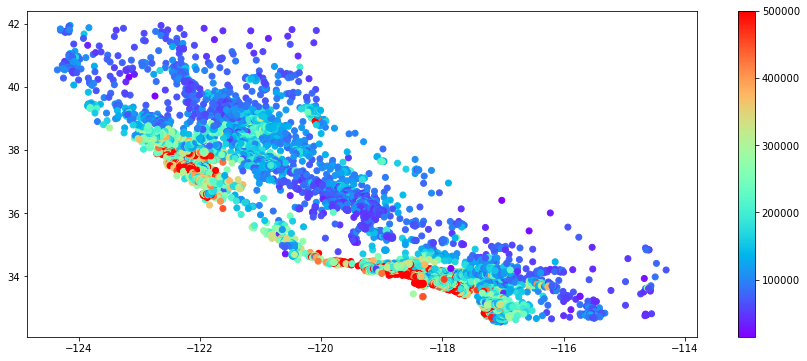

In [4]:
#Visualizando os dados e comparando a posição das casas com a nossa variável target.

plt.figure(figsize=[15,6])
plt.scatter(df.longitude, df.latitude, c=df.preco_mediano_das_casas, cmap='rainbow')
plt.colorbar()
plt.show()

In [5]:
#Quanto mais próximo ao mar maior o preço mediano das casas.
#Verificando como se dividem as categorias de proximidade:

df.proximidade_ao_mar.value_counts()

<1H OCEANO       9136
INTERIOR         6551
PERTO OCEANO     2658
PERTO DA BAÍA    2290
ILHA                5
Name: proximidade_ao_mar, dtype: int64

In [6]:
#Transformando a categoria proximidade ao mar em numérica:

df.proximidade_ao_mar = df.proximidade_ao_mar.map({'<1H OCEANO':0,'INTERIOR':1,'PERTO OCEANO':2,'PERTO DA BAÍA':3,'ILHA':4,})

In [7]:
df.proximidade_ao_mar.value_counts()

0    9136
1    6551
2    2658
3    2290
4       5
Name: proximidade_ao_mar, dtype: int64

In [8]:
#Verificando valores da correlação de pearson:
df.corr(method='pearson')

,longitude,latitude,idade_mediana_das_casas,total_comodos,total_quartos,populacao,familias,salario_mediano,preco_mediano_das_casas,proximidade_ao_mar
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967,-0.439870
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160,0.390957
idade_mediana_das_casas,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623,0.145163
total_comodos,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153,-0.016309
total_quartos,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686,-0.021466
populacao,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650,-0.083537
familias,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843,-0.027144
salario_mediano,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075,-0.039673
preco_mediano_das_casas,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000,0.021732
proximidade_ao_mar,-0.439870,0.390957,0.145163,-0.016309,-0.021466,-0.083537,-0.027144,-0.039673,0.021732,1.000000


A correlação de pearson entre salários médios e o preço mediano das casas é bem expressiva e faz sentido que seja. A proximidade ao mar não detém uma correlação de pearson tão boa naturalmente já que ela não é originalmente numérica, ainda sim ela segue fazendo sentido.

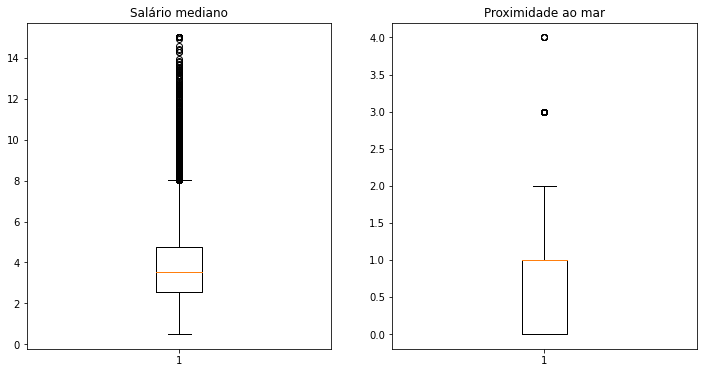

In [9]:
#Verificando outliers:

plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.boxplot(df.salario_mediano)
plt.title('Salário mediano')
plt.subplot(1,2,2)
plt.boxplot(df.proximidade_ao_mar)
plt.title('Proximidade ao mar')
plt.show()

Como vemos há muitos outliers na variável salário mediano, e o natural seria limpar outliers no pré-processamento dos dados. Nesse caso específico como nossa variável target são preços de casas, que variam muito, não retirarei esses outliers porque eles provavelmente não o são de fato. Casas mais caras exigem rendas melhores.
<br>
<br>
Efeito semelhante ocorre com a proximidade ao mar onde o 3 aparece como outlier mas ele marca as casas próximas a baía, provavelmente mais caras, seria uma opção eliminar as casas em ilhas por representarem um número muito baixo.
<br>
<br>
Como variável preditora decidi utilizar o salário mediano pra facilitar o uso do contexto de regressão:

In [10]:
#Preparando dados para os algoritmos:

x = df.salario_mediano.to_numpy()
y = df.preco_mediano_das_casas.to_numpy()

x.shape,y.shape

((20640,), (20640,))

In [11]:
#reshape para evitar problemas:

x = x.reshape(-1,1)
y = y.reshape(-1,1)

x.shape, y.shape

((20640, 1), (20640, 1))

In [12]:
#Divisão dos dados em treino e teste:

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.30, random_state=0)

# Utilizando o GridSearch

In [15]:
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor


### RandomForestRegressor

In [16]:
#Estimador base:
e_base = RandomForestRegressor()
#Parâmetros:
parametros = {"n_estimators":[10,1000], "max_depth":range(2,10)}

In [17]:
#Instanciando o grid:
grid = GridSearchCV(estimator = e_base, 
                    param_grid = parametros, 
                    scoring = 'r2', 
                    cv = 5,
                    n_jobs = -1)

grid

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 10), 'n_estimators': [10, 1000]},
             scoring='r2')

In [18]:
%%time
#Fitando o treino:
grid.fit(x_train, y_train)

Wall time: 37.2 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 10), 'n_estimators': [10, 1000]},
             scoring='r2')

In [19]:
#Melhores parâmetros:
grid.best_params_

{'max_depth': 4, 'n_estimators': 1000}

In [20]:
#Melhor pontuação de r²:
grid.best_score_

0.49507283285183074

### KNN regressor:

In [21]:
#Estimador base:
e_base = KNeighborsRegressor()
#Parâmetros:
parametros = {"n_neighbors":[1,15]}

In [22]:
#Instanciando o Grid:
grid = GridSearchCV(estimator = e_base, 
                    param_grid = parametros, 
                    scoring = 'r2', 
                    cv = 5,
                    n_jobs = -1)

grid

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 15]}, scoring='r2')

In [23]:
#Fitando:
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 15]}, scoring='r2')

In [24]:
#Melhores parâmetros:
grid.best_params_

{'n_neighbors': 15}

In [25]:
#Melhor pontuação de r²:
grid.best_score_

0.46497560079056904

### GradientBoostingRegressor

In [26]:
#Estimador base:
e_base = GradientBoostingRegressor()
#Parâmetros:
parametros = {"n_estimators":range(1,10),"learning_rate":[0.01,0.1,0.3,0.5], "max_depth":range(2,10),"max_features":['auto', 'sqrt', 'log2']}

In [27]:
#Instanciando o Grid:
grid = GridSearchCV(estimator = e_base, 
                    param_grid = parametros, 
                    scoring = 'r2', 
                    cv = 5,
                    n_jobs = -1)

grid

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5],
                         'max_depth': range(2, 10),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': range(1, 10)},
             scoring='r2')

In [28]:
%%time
#Fitando:
grid.fit(x_train,y_train)

Wall time: 21.6 s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5],
                         'max_depth': range(2, 10),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': range(1, 10)},
             scoring='r2')

In [29]:
#Melhores parâmetros:
grid.best_params_

{'learning_rate': 0.3,
 'max_depth': 3,
 'max_features': 'auto',
 'n_estimators': 9}

In [30]:
#Melhor pontuação de r²:
grid.best_score_

0.49335234468736255

### Criando uma classe para o gridsearch que recebe vários modelos e os treina:

In [31]:
class gridSearchAll():
    
    def __init__(self, scoring, num_folds):
        self.grid_models = []
        self.scoring = scoring
        self.num_folds = num_folds
    
    def insert_model(self, estimator_base, param_grid): #Insere os modelos e parâmetros:
        self.grid_models.append([estimator_base, param_grid])
        return("Modelos inseridos com sucesso!")
        
    def fit_all(self,x,y): #Treina o modelo.
        self.best_model = pd.DataFrame(columns=['models', 'best_params', 'scoring']) #Cria um dataframe para salvar os resultados
        for models, param in self.grid_models:
            grid = GridSearchCV(estimator = models, 
                                param_grid = param, 
                                scoring = self.scoring, 
                                cv = self.num_folds,
                                n_jobs=-1) #Utilização máxima do processador.
            grid.fit(x,y)
            self.best_model.loc[self.grid_models.count(models)] = [models,grid.best_params_,grid.best_score_] #Adiciona linhas no df
            
        return print("Modelos treinados")
            
    def best_all_grid_models(self): #Retorna os melhores parâmetros:
        best_scoring = self.best_model
        return best_scoring
        

### Utilizando a classe para refazer o gridsearch da primeira parte:

In [32]:
megagrid = gridSearchAll('r2',5)

In [33]:
megagrid.insert_model(estimator_base = KNeighborsRegressor() , param_grid= {"n_neighbors":[1,15]})
megagrid.insert_model(estimator_base = GradientBoostingRegressor() , param_grid= {"n_estimators":range(1,10),
                                                                                  "learning_rate":[0.01,0.1,0.3,0.5], 
                                                                                  "max_depth":range(2,10),
                                                                                  "max_features":['auto', 'sqrt', 'log2']})
megagrid.insert_model(estimator_base = RandomForestRegressor(),param_grid= {"n_estimators":[10,1000], 
                                                                            "max_depth":range(2,10)})

'Modelos inseridos com sucesso!'

In [34]:
megagrid.grid_models

[[KNeighborsRegressor(), {'n_neighbors': [1, 15]}],
 [GradientBoostingRegressor(),
  {'n_estimators': range(1, 10),
   'learning_rate': [0.01, 0.1, 0.3, 0.5],
   'max_depth': range(2, 10),
   'max_features': ['auto', 'sqrt', 'log2']}],
 [RandomForestRegressor(),
  {'n_estimators': [10, 1000], 'max_depth': range(2, 10)}]]

In [35]:
%%time
megagrid.fit_all(x_train,y_train)

Modelos treinados
Wall time: 55.3 s


In [36]:
megagrid.best_all_grid_models()

,models,best_params,scoring
0,RandomForestRegressor(),"{'max_depth': 4, 'n_estimators': 1000}",0.495149
